**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Autoencoder para colorear imagenes

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Referencias

1. Basadado en Rowel Atieza, [Advanced Deep Learning with TensorFlow 2 and Keras](https://www.amazon.com/-/es/Rowel-Atienza-ebook/dp/B0851D5YQQ), 2020.

## Contenido

* [Introducción](#Introducción)
* [Importa módulos](#Importa-módulos)
* [ Función para convertir una imagen a color en tonos de gris](#Función-para-convertir-una-imagen-a-color-en-tonos-de-gris)
* [Los datos](#Los-datos)
* [Configuración](#Configuración)
* [Encoder](#Encoder)
* [Decoder](#Decoder)
* [Autoencoder](#Autoencoder)
* [Callbacks](#Callbacks)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones y gráficas](#Predicciones-y-gráficas)

## Introducción

Construimos un autoencoder para colorear imágenes en tonos de grises

## Importa módulos

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
  
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.datasets import cifar100 
from tensorflow.keras.utils import plot_model

## Función para convertir una imagen a color en tonos de gris

In [ ]:
def rgb_2_gray(image): 
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]) 

## Los datos

Los datos son de la base [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html) creados en la Universidad de Toronto.

### Lee datos

In [ ]:
(x_train, _), (x_test, _) = cifar100.load_data() 
print(x_train.shape)
print(x_test.shape)

169009152/169001437 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Crea imágenes en escala de grises

In [ ]:
x_train_gray = x_train[..., :3]@[0.299, 0.587, 0.114]
x_test_gray  = x_test[..., :3]@[0.299, 0.587, 0.114]

# Reshape to the model
x_train_gray = np.expand_dims(x_train_gray , axis=3)
x_test_gray = np.expand_dims(x_test_gray, axis=3)

print(x_train_gray.shape)
print(x_test_gray.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


### Normaliza datos

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
  
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

## Configuración

In [ ]:
rows = x_train.shape[1]
cols = x_train.shape[2]
channels = x_train.shape[3]

input_shape = (rows, cols, 1) 
batch_size = 256
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256] 

## Encoder

In [ ]:
inputs = Input(shape = input_shape) 
x = inputs 
for filters in layer_filters: 
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 2, 
               activation ='relu', 
               padding ='same')(x) 

# Save the shape to the decoder
shape = x.shape.as_list()
# shape = shape[1:]

x = Flatten()(x) 
latent = Dense(latent_dim, name ='latent_vector')(x) 
encoder_colorizing = Model(inputs, latent, name ='encoder_colorizing') 

### Summary

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
______________________________________

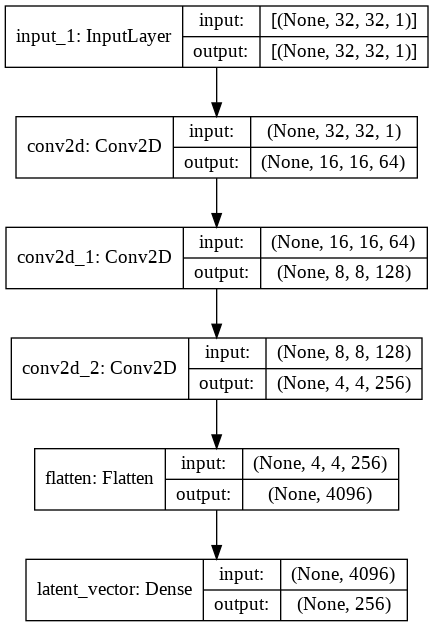

In [ ]:
encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

## Decoder

In [ ]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input') 
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) 
x = Reshape((shape[1], shape[2], shape[3]))(x) 
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)- 
# Conv2DTranspose(64) 
for filters in layer_filters[::-1]: 
    x = Conv2DTranspose(filters = filters, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(x) 

outputs = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(x)
decoder_colorizing = Model(latent_inputs, outputs, name ='decoder_colorizing') 

In [ ]:
for filters in layer_filters: 
  x = Conv2D(filters = filters, 
           kernel_size = kernel_size, 
           strides = 2, 
           activation ='relu', 
           padding ='same')(x) 

### Summary

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)  

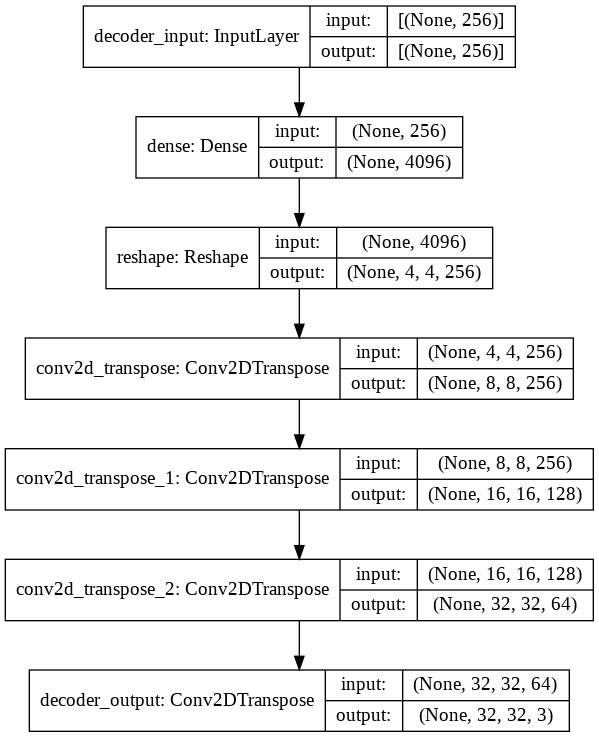

In [ ]:
decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

## Autoencoder

In [ ]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing') 

### Summary

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 256)               1418496   
_________________________________________________________________
decoder_colorizing (Function (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


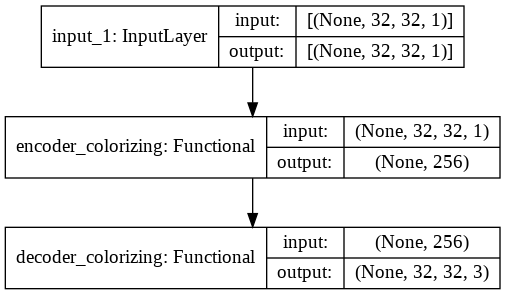

In [ ]:
autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

## Callbacks

In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

## Compila

In [ ]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

## Entrena


autoencoder_colorizing.fit(x_train_gray, 
                x_train, 
                validation_data =(x_test_gray, x_test), 
                epochs = epochs, 
                batch_size = batch_size) 


In [ ]:
epochs = 10

history=autoencoder_colorizing.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/10
196/196 [==============================] - 13s 64ms/step - loss: 0.0129 - mae: 0.0806 - val_loss: 0.0118 - val_mae: 0.0758

Epoch 00001: val_loss did not improve from 0.01154
Epoch 2/10
196/196 [==============================] - 12s 63ms/step - loss: 0.0105 - mae: 0.0718 - val_loss: 0.0119 - val_mae: 0.0766

Epoch 00002: val_loss did not improve from 0.01154
Epoch 3/10
196/196 [==============================] - 12s 63ms/step - loss: 0.0102 - mae: 0.0712 - val_loss: 0.0113 - val_mae: 0.0741

Epoch 00003: val_loss improved from 0.01154 to 0.01133, saving model to /content/saved_models/colorized_ae_model.003.h5
Epoch 4/10
196/196 [==============================] - 12s 64ms/step - loss: 0.0099 - mae: 0.0700 - val_loss: 0.0113 - val_mae: 0.0733

Epoch 00004: val_loss improved from 0.01133 to 0.01126, saving model to /content/saved_models/colorized_ae_model.004.h5
Epoch 5/10
196/196 [==============================] - 12s 64ms/step - loss: 0.0096 - mae: 0.0694 - val_loss: 0.0115 - 

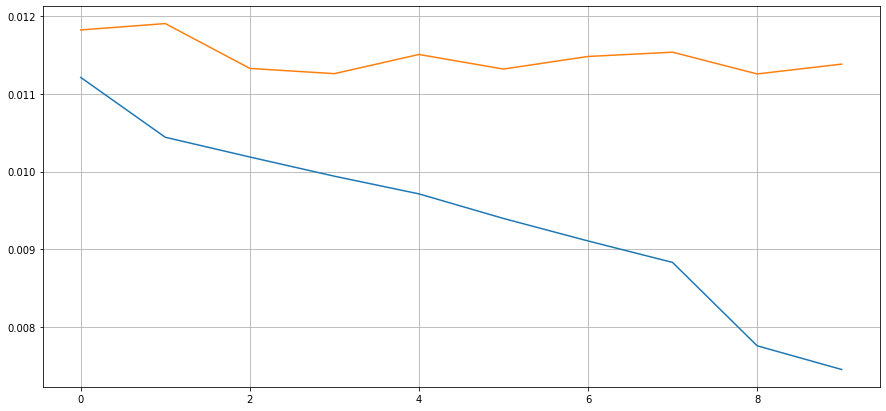

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

## Predicciones y gráficas

In [ ]:
x_decoded = autoencoder_colorizing.predict(x_test_gray)

### Imágenes originales

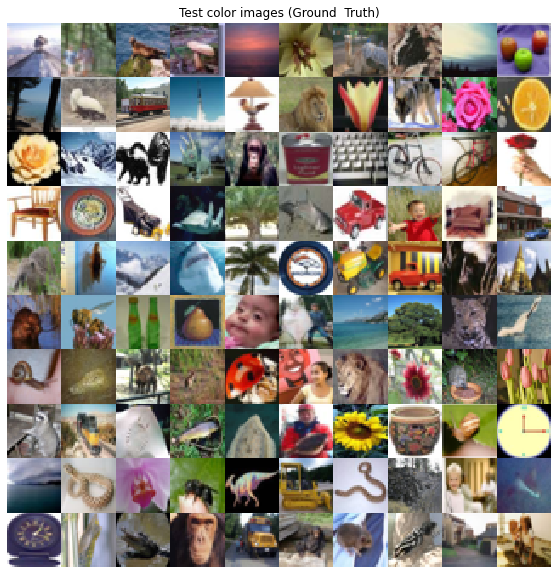

In [ ]:
# display the 1st 100 input images (color and gray)

img_rows = rows
img_cols = cols

imgs_t = x_test[:100]
imgs_t = imgs_t.reshape((10, 10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test_color.png')
plt.show()

### Imágenes en escala de grises

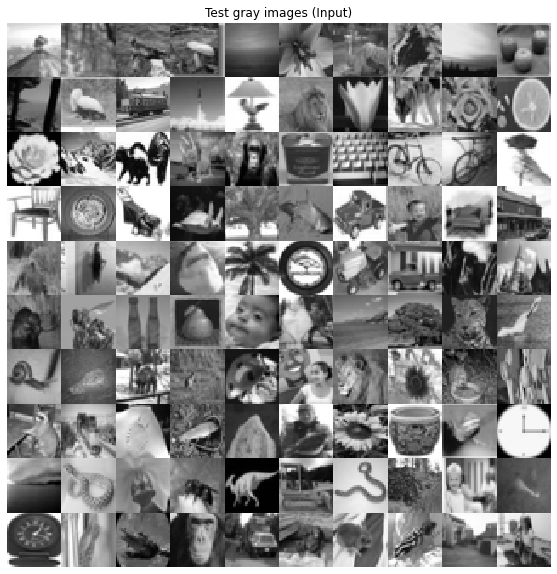

In [ ]:
# display grayscale version of test images
imgs_g = x_test_gray[:100]
imgs_g = imgs_g.reshape((10, 10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs_g, interpolation='none', cmap='gray')
plt.savefig('./test_gray.png')
plt.show()

### Primeras 100 imágenes coloreadas

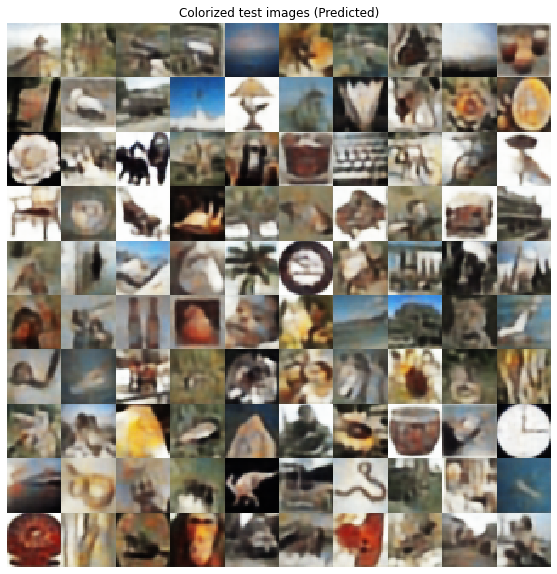

In [ ]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

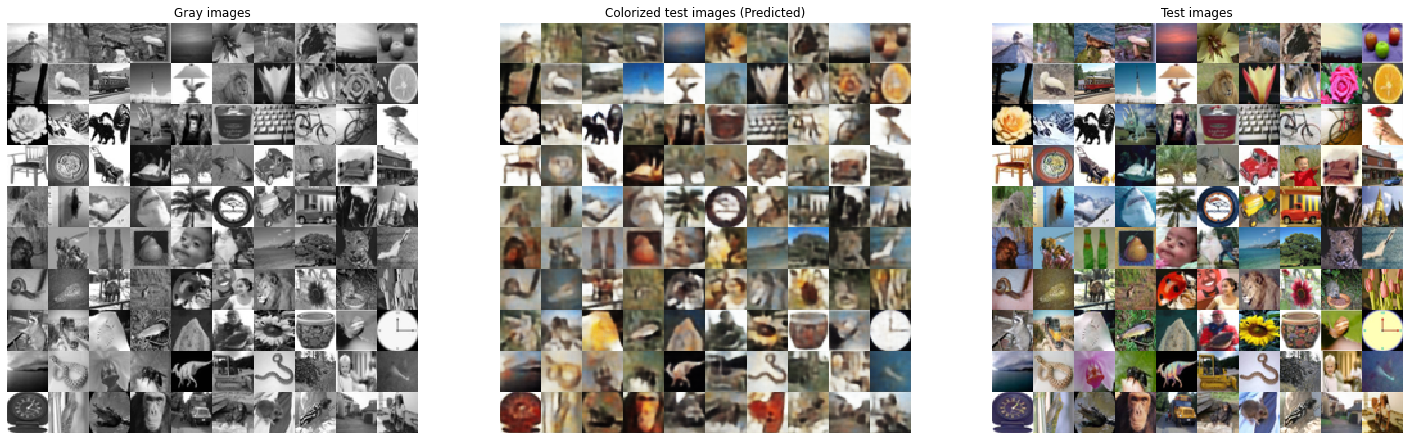

In [ ]:
plt.figure(figsize=(25,25))
plt.subplot(131)
plt.axis('off')
plt.title('Gray images')
plt.imshow(imgs_g, interpolation='none',cmap='gray')
plt.savefig('./test.png')

plt.subplot(132)
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

plt.subplot(133)
plt.axis('off')
plt.title('Test images')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test.png')

plt.show()